Core Transactional Data

* transactionTime: The date and time the transaction was requested.
* eventId: A unique string identifier for the transaction.
* accountNumber: The account number associated with the transaction.
* merchantId: A unique string identifier for the merchant.
* mcc: Merchant Category Code (represents the merchant's business type).
* merchantCountry: The country where the merchant is located.
* merchantZip: Truncated/partial zip code of the merchant's location.
* posEntryMode: Point of Sale entry mode (e.g., manual, chip card, e-commerce).
* transactionAmount: The value of the transaction (presumably in GBP).
* availableCash: Rounded amount available in the account prior to the transaction.



Events data
* is_fraud: This sis the target variable to be used in the model building. 0 indicates normal transaction, 1 indicate fraud
* reportedTime: The time the transaction was reported (assuming different from 'transactionTime').

Derived / Calculated Features
* posEntryMode_description: Text description of the 'posEntryMode' code.
* transaction_hour: Hour extracted from 'transactionTime'.
* transaction_day: Day extracted from 'transactionTime'.
* transaction_month: Month extracted from 'transactionTime'.
* time_since_last_transaction: Time difference between the current and previous transaction for the same account.
* amount_to_available_cash_ratio: Ratio of the transaction amount to the available cash before the transaction.
* amount_binned: Category of the transaction amount (e.g., low, medium, high).
* amount_deviation_from_account_avg: Transaction amount deviation from account average
* transactions_per_account: Count of transactions associated with each account.
* average_transaction_amount_per_account: Average transaction amount for each account.
* is_new_merchant: Indicates if the transaction is the first interaction between the account and merchant.
* merchant_risk_score: A calculated risk score for each merchant, potentially based on fraud rates.
* zip_code_risk_score: A calculated risk score for each merchant zipcode, potentially based on fraud rates.



Temporal Features:
Time of day (transactionTime)
Day of the week (transactionTime)
Weekend/weekday indicator (transactionTime)
Time difference between transactionTime and reportedTime
Account-related Features:
Account number (accountNumber)
Available cash balance (availableCash)
Transaction amount to available cash ratio (transactionAmount / availableCash)
Merchant-related Features:
Merchant ID (merchantId)
Merchant category code (mcc)
Merchant country (merchantCountry)
Merchant zip code (merchantZip)
Transaction-related Features:
Point of sale entry mode (posEntryMode)
Transaction amount (transactionAmount)
Derived Features:
Time since the last transaction for the account
Number of transactions within a specific time window for the account
Average transaction amount for the account within a specific time window
Number of unique merchants for the account within a specific time window
Number of transactions for the merchant within a specific time window
Average transaction amount for the merchant within a specific time window
Categorical Features:
One-hot encoding or label encoding for categorical variables like posEntryMode, mcc, and merchantCountry
Aggregated Features:
Count of transactions, sum of transaction amounts, or other aggregated features grouped by account, merchant, or time windows
Interaction Features:
Interactions between different features, such as account number and merchant ID, transaction amount and available cash, etc.
Velocity Features:
Number of transactions within a specific time window for the account
Number of transactions within a specific time window for the merchant

If the cost of a false positive (flagging a legitimate transaction) is high (e.g., customer inconvenience), prioritize precision.
If the cost of a false negative (missing a fraudulent transaction) is high (e.g., financial loss), prioritize recall.
F1-score offers a balance, but consider the relative costs of each error type in your scenario.
AUC-ROC provides a more comprehensive view of model performance across different thresholds.

In [2]:
from src.data.make_dataset import run_data_preparation
from src.train.model_utils import (
    prepare_data_for_modeling,
    split_into_xy,
    perform_stratified_split,
    apply_smote,
    build_catboost_model,
    perform_grid_search,
    evaluate_model,
)
from src.config import (
    EVENT_ID,
    FEATURES,
    LABEL,
    DATA_DIR,
    CATEGORICAL_FEATURES,
    CATBOOST_PARAM_GRID,
)

from src.train.cost_analysis import cost_and_savings_analysis
from src.train.visualizations import plot_feature_importances

## DATA

In [2]:

transaction_df = run_data_preparation(data_dir=DATA_DIR)

In [3]:
print("------------- full dataset ---------------")
# transaction_df = run_data_preparation(DATA_DIR)

print(f'total transactions in test data: {transaction_df.is_fraud.value_counts()}')
print(f'fraud rate: {transaction_df.is_fraud.mean():.4f}')
print(f'total amount lost due to fraud: £{transaction_df[transaction_df["is_fraud"] == 1]["transactionAmount"].sum():.2f}')

#  transactionTime range
print(f'transactionTime range: {transaction_df.transactionTime.min()} - {transaction_df.transactionTime.max()}')

------------- full dataset ---------------
total transactions in test data: is_fraud
0    117746
1       875
Name: count, dtype: int64
fraud rate: 0.0074
total amount lost due to fraud: £100772.58
transactionTime range: 2017-01-01 00:00:00+00:00 - 2018-01-31 00:04:44+00:00


## Model Training

In [4]:
# Data preparation for modeling
development_df, test_df = prepare_data_for_modeling(
    data_dir=DATA_DIR, event_id=EVENT_ID, features=FEATURES, label=LABEL
)


In [5]:
# Split data X,y
X, y = split_into_xy(development_df)

# Split data into train and validation
X_train, X_val, y_train, y_val = perform_stratified_split(X, y)

# set eventId as index
X_train = X_train.set_index('eventId')
X_val = X_val.set_index('eventId')



In [6]:
X_train.columns

Index(['time_since_last_transaction', 'transaction_day',
       'std_transaction_amount_per_account',
       'amount_deviation_from_account_avg', 'merchent_zip3_country',
       'availableCash', 'transactionAmount', 'merchantCountry',
       'amount_to_available_cash_ratio', 'transaction_hour',
       'average_transaction_amount_per_account', 'transactions_per_account',
       'is_new_merchant', 'posEntryMode', 'mcc'],
      dtype='object')

In [8]:
# Apply SMOTE
X_train_balanced, y_train_balanced = apply_smote(
    X_train, y_train, CATEGORICAL_FEATURES
)



In [ ]:
# Build CatBoost model
model = build_catboost_model()

# Perform Grid Search and select best model
best_model = perform_grid_search(
    model,
    param_grid=CATBOOST_PARAM_GRID,
    X=X_train_balanced,
    y=y_train_balanced,
    cat_features=CATEGORICAL_FEATURES,
)

## Feature importance

In [7]:
# Get feature importances
feature_importances = best_model.get_feature_importance(prettified=True) 

In [8]:
feature_importances

,Feature Id,Importances
0,availableCash,19.099997
1,mcc,12.662648
2,merchent_zip3_country,11.549600
3,transaction_day,9.704662
4,posEntryMode,8.737876
5,transactions_per_account,7.593831
6,merchantCountry,6.145167
7,transaction_hour,4.783410
8,std_transaction_amount_per_account,4.095048
9,is_new_merchant,3.901777


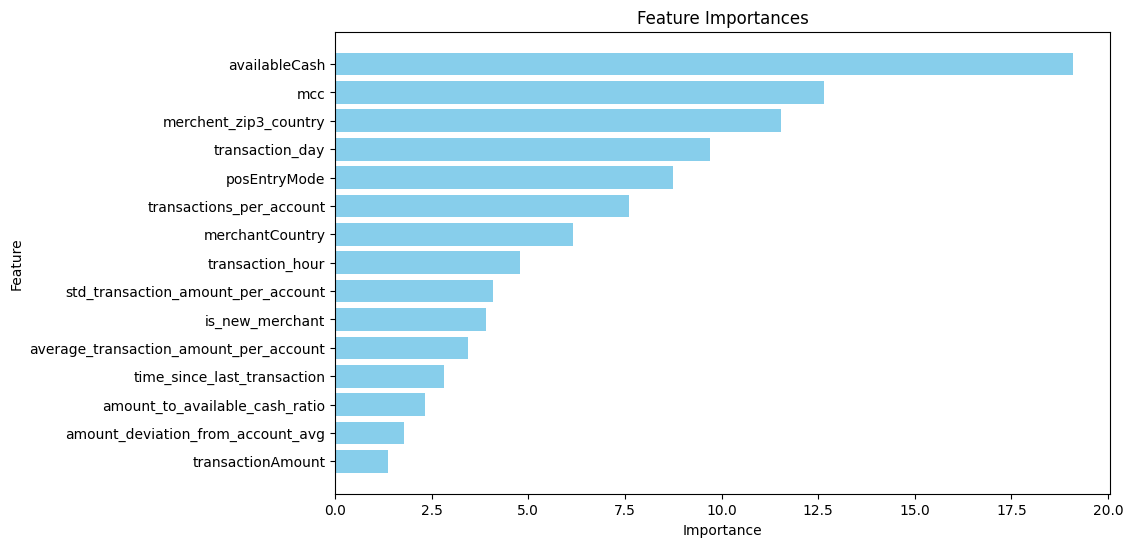

In [9]:
plot_feature_importances(feature_importances)

# Evaluation


In [10]:

evaluate_model(best_model, X_train, y_train)
#
#evaluate_model(best_model, test_df, test_df["is_fraud"])

Confusion Matrix:
 [[99742   947]
 [    8   724]]
Precision: 0.43327348892878514
Recall: 0.9890710382513661
F1 Score: 0.6025801081980857
ROC AUC Score: 0.9898329200334287


In [11]:
evaluate_model(best_model, X_val, y_val)

Confusion Matrix:
 [[11068   120]
 [   14    67]]
Precision: 0.3582887700534759
Recall: 0.8271604938271605
F1 Score: 0.5
ROC AUC Score: 0.9082173581041416


In [12]:
X_test, y_test = split_into_xy(test_df)
X_test = X_test.set_index('eventId')
evaluate_model(best_model, X_test, y_test)

Confusion Matrix:
 [[5771   98]
 [  19   43]]
Precision: 0.3049645390070922
Recall: 0.6935483870967742
F1 Score: 0.4236453201970443
ROC AUC Score: 0.8384252414270718


In [14]:
y_test.value_counts()

is_fraud
0    5869
1      62
Name: count, dtype: int64

In [16]:
test_df['predicted_label'] = best_model.predict(X_test)

,std_transaction_amount_per_account,is_fraud,average_transaction_amount_per_account,merchantCountry,is_new_merchant,eventId,transaction_hour,time_since_last_transaction,posEntryMode,transactions_per_account,transaction_day,merchent_zip3_country,amount_deviation_from_account_avg,mcc,transactionAmount,amount_to_available_cash_ratio,availableCash,predicted_label
0,0.027936,0,0.024102,826,False,15275438A1,5,0.004605,5,0.128909,26,NN6826,0.067015,8021,0.005076,0.009013,0.388889,0
1,0.064695,0,0.032734,826,False,40365107A1,18,0.014012,81,0.168574,6,EC1826,0.066067,7922,0.003670,0.006512,0.388889,0
2,0.030069,0,0.032777,826,False,85816158A1,5,0.008100,1,0.471396,1,GL1826,0.062512,4816,0.000590,0.000618,0.666667,0
3,0.037044,0,0.009174,442,False,90766552A1,16,0.010275,81,0.204424,7,nan442,0.064264,5735,0.000234,0.000220,0.722222,0
4,0.011977,0,0.014729,826,False,33887872A1,6,0.000024,1,0.070938,7,0826,0.064464,9222,0.001959,0.017333,0.055556,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5926,0.035899,0,0.024562,826,False,102772024A1,23,0.002604,5,0.651411,4,IV3826,0.068161,5499,0.006162,0.009659,0.444444,0
5927,0.021971,0,0.019416,826,False,84982375A1,2,0.000225,5,0.728452,3,SS7826,0.069134,5411,0.006931,0.012316,0.388889,0
5928,0.068476,0,0.021530,826,False,9096058A1,18,0.003541,5,0.238749,28,CA2826,0.063720,5714,0.000626,0.001824,0.222222,0
5929,0.029896,0,0.048020,826,False,79288453A1,16,0.000100,5,0.045004,24,DN3826,0.061023,5411,0.002783,0.024667,0.055556,0


## Cost Analysis

The cost of a fraudulent transaction can be higher than just the transaction amount: operational cost, chargeback fees, fines and penalities, reputational damage and opprtunity cost etc. to account this 
fraud_cost_multiplier = 5 used to estimate the total cost.

In [127]:


print("------------- test dataset ---------------")
test_df = (transaction_df[['eventId', 'transactionAmount']]
           .merge(test_df[['eventId', 'is_fraud', 'predicted_label']], on='eventId', how='inner'))

print(f'total transactions in test data: {test_df.is_fraud.value_counts()}')
print(f'fraud rate in test data: {transaction_df.is_fraud.mean():.4f}')
print(f'total transaction amount test data: £{transaction_df["transactionAmount"].sum():.2f}')
print(f'fraud transaction amount test data: £{transaction_df[transaction_df["is_fraud"] == 1]["transactionAmount"].sum():.2f}')

------------- test dataset ---------------
total transactions in test data: is_fraud
0    5869
1      62
Name: count, dtype: int64
fraud rate in test data: 0.0074
total transaction amount test data: £6366955.32
fraud transaction amount test data: £100772.58


In [ ]:
estimated_savings, false_negative_cost, total_transaction_amount, fraud_cost_without_model = cost_and_savings_analysis(test_df)
print(f"Total Transaction Amount: £{total_transaction_amount:.2f}")
print(f"Cost Due to False Negatives: £{false_negative_cost:.2f}")
print(f"Fraud Cost Without Model: £{fraud_cost_without_model:.2f}")
print(f"Estimated Savings: £{estimated_savings:.2f}")